# Sequence-to-Sequence Models

Sequence to sequence models comprise of **two recurrent neural networks (RNNs)**: an **encoder** that processes the input and a **decoder** that generates the output.

The task of encoder is to generate an efficient representation of input sequence which be used by the decoder network for generating the output in context that we train the decoder in. 

Consider the task of language translation or something complex such as captioning of images. The task of encoder is to learn structures in the input data (text/images) and generate an n-dimensional representation of the input data, which we refer to as the hidden state.
The hidden state vector is then fed to a decoder network to generate output sequences. These are very powerful model which have been deployed for tasks such as:
    1. Neural Machine Translation
    2. Image captioning
    3. Generating subtitles for songs/audio
    4. Image generation from text! etc.
    
The encoder network can also be seen as an embedding network, which reduces the dimensionality of data and embeds the input sequences into n dimensions. These networks can be used for sequential data compression, where we can store humongous amounts of data as n-dimensional vectors. The weights of the encoder-RNN and decoder-RNN can be stored seperately along with the network configuration. We can expand the compressed data using the decoder network. Just imagine terrabytes of audio data being stored in just n-dimensional vectors!

In this task, we implement a sequence-to-sequence model for the task of replicating input sequences. The idea is to create a compressed representation of input sequence using an encoder RNN, and use this hidden state and decoder-RNN to generate the input sequence!

Let's dive in!

In [1]:
import numpy as np #matrix math 
import tensorflow as tf #machine learningt
import helpers #for formatting data into batches and generating random sequence data

tf.reset_default_graph() #Clears the default graph stack and resets the global default graph.
sess = tf.InteractiveSession() #initializes a tensorflow session

In [2]:
tf.__version__

'1.0.1'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20 #character length

encoder_hidden_units = 20 #num neurons
decoder_hidden_units = encoder_hidden_units * 2 #in original paper, they used same number of neurons for both encoder

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#this thing could get huge in a real world application
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [6]:
from tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:
with tf.variable_scope('rnn'):
    ((encoder_fw_outputs,
      encoder_bw_outputs),
     (encoder_fw_final_state,
      encoder_bw_final_state)) = (tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                        cell_bw=encoder_cell,
                                        inputs=encoder_inputs_embedded,
                                        sequence_length=encoder_inputs_length,
                                        dtype=tf.float32, time_major=True))

In [9]:
encoder_fw_outputs

<tf.Tensor 'rnn/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_bw_outputs

<tf.Tensor 'rnn/ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [11]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [16]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [17]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [18]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [19]:
decoder_lengths = encoder_inputs_length + 3

In [20]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [21]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

#retrieves rows of the params tensor. The behavior is similar to using indexing with arrays in numpy
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)


In [22]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    #end of sentence
    initial_input = eos_step_embedded
    #last time steps cell state
    initial_cell_state = encoder_final_state
    #none
    initial_cell_output = None
    #none
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [23]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    
    
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [24]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [25]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [26]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [27]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [28]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [29]:
sess.run(tf.global_variables_initializer())

In [30]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[7, 9, 6, 9, 9]
[6, 6, 5, 4, 6, 2, 7]
[9, 5, 2]
[2, 6, 6, 4, 2]
[5, 5, 3]
[9, 9, 7, 2, 2]
[7, 5, 3, 6]
[5, 2, 4, 3]
[3, 5, 9, 4, 5]
[4, 2, 7, 6]


In [31]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [32]:
loss_track = []

In [33]:
max_batches = 5001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.38790130615
  sample 1:
    input     > [2 2 3 2 3 5 3 0]
    predicted > [2 2 1 9 2 9 9 9 2 9 0]
  sample 2:
    input     > [2 5 8 0 0 0 0 0]
    predicted > [2 2 1 9 9 9 0 0 0 0 0]
  sample 3:
    input     > [7 7 5 3 3 6 0 0]
    predicted > [7 7 7 7 7 7 7 7 7 0 0]
()
batch 1000
  minibatch loss: 0.481568276882
  sample 1:
    input     > [6 6 8 9 0 0 0 0]
    predicted > [6 8 6 9 1 0 0 0 0 0 0]
  sample 2:
    input     > [3 9 2 3 5 0 0 0]
    predicted > [3 9 2 3 5 1 0 0 0 0 0]
  sample 3:
    input     > [5 9 2 2 2 5 2 0]
    predicted > [5 5 2 2 2 2 2 1 0 0 0]
()
batch 2000
  minibatch loss: 0.206333577633
  sample 1:
    input     > [3 8 7 3 9 4 9 0]
    predicted > [3 8 7 3 9 9 9 1 0 0 0]
  sample 2:
    input     > [4 5 7 4 9 4 0 0]
    predicted > [4 5 7 4 9 4 1 0 0 0 0]
  sample 3:
    input     > [4 4 2 3 0 0 0 0]
    predicted > [4 4 2 3 1 0 0 0 0 0 0]
()
batch 3000
  minibatch loss: 0.0798834934831
  sample 1:
    input     > [4 4 9 7 5 0 0 0

loss 0.0292 after 500100 examples (batch_size=100)


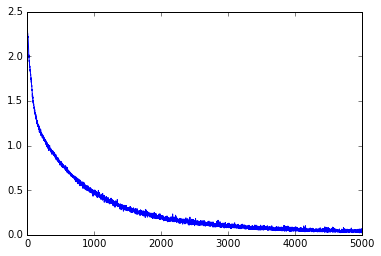

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

## Results

As the graph of training loss suggests, the network trains as we expect. Notice the output sequences generated as the number of epochs over mini-batches increases. The ability of the model to generate exact input sequences grows as the model trains over each epoch; just as we predicted!